In [4]:
!pip install langchain-community

In [ ]:
!pip install langchain networkx sentence-transformers faiss-cpu openai


In [1]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY_1"


In [9]:
import os
import networkx as nx
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# --- Step 1: Load documents (Example: Simple paragraphs) ---
docs = [
    "The Eiffel Tower is located in Paris.",
    "Paris is the capital city of France.",
    "France is a country in Europe.",
    "The Great Wall is in China.",
    "China has the largest population in the world.",
    "Mount Everest is the highest mountain and lies in the Himalayas.",
]

# --- Step 2: Convert documents to embeddings ---
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs, convert_to_tensor=False)

# --- Step 3: Build a FAISS index for retrieval ---
dimension = embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# --- Step 4: Create a graph based on similarity (e.g., top-2 neighbors) ---
G = nx.Graph()
for i, doc in enumerate(docs):
    G.add_node(i, text=doc, embedding=embeddings[i])
    D, I = index.search(np.array([embeddings[i]]), 3)  # include self
    for j in I[0][1:]:
        G.add_edge(i, j)

# --- Step 5: Graph-Aware Retrieval ---
def graph_rag_query(query, top_k=3):
    q_embedding = model.encode([query])[0]
    D, I = index.search(np.array([q_embedding]), top_k)

    # Traverse the graph to expand the context
    retrieved_texts = set()
    for idx in I[0]:
        retrieved_texts.add(G.nodes[idx]['text'])
        for neighbor in G.neighbors(idx):
            retrieved_texts.add(G.nodes[neighbor]['text'])

    return list(retrieved_texts)[:top_k + 2]

# --- Step 6: Use LangChain + OpenAI to answer ---

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Use the following context to answer the question.
Context:
{context}

Question:
{question}
Answer:
"""
)

def generate_answer(question):
    context = graph_rag_query(question)
    prompt = prompt_template.format(context="\n".join(context), question=question)
    return llm.predict(prompt)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The provided text doesn't state where the Eiffel Tower is located.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Mount Everest


In [10]:
# --- Example Query ---
print(generate_answer("Where is the Eiffel Tower?"))
print(generate_answer("What is the tallest mountain?"))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The provided text doesn't state where the Eiffel Tower is.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Mount Everest


In [1]:
!pip install networkx plotly sentence-transformers faiss-cpu


In [4]:
import networkx as nx
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import plotly.graph_objects as go

# --- Step 1: Prepare the data ---
docs = [
    "The Eiffel Tower is located in Paris.",
    "Paris is the capital city of France.",
    "France is a country in Europe.",
    "The Great Wall is in China.",
    "China has the largest population in the world.",
    "Mount Everest is the highest mountain and lies in the Himalayas.",
]

query = "Where is the Eiffel Tower?"

# Embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs + [query])
doc_embeddings = embeddings[:-1]
query_embedding = embeddings[-1]

# FAISS index
dimension = doc_embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(doc_embeddings))

# Build graph
G = nx.Graph()
for i, text in enumerate(docs):
    G.add_node(i, label=text, is_query=False)

# Add similarity-based edges
for i in range(len(docs)):
    D, I = index.search(np.array([doc_embeddings[i]]), 3)
    for j in I[0][1:]:
        G.add_edge(i, j)

# Add the query node
query_node = len(docs)
G.add_node(query_node, label=query, is_query=True)
D, I = index.search(np.array([query_embedding]), 2)
for i in I[0]:
    G.add_edge(query_node, i)

# --- Step 2: Assign 3D positions ---
pos = nx.spring_layout(G, dim=3, seed=42)
node_xyz = np.array([pos[i] for i in G.nodes()])
edge_xyz = [(pos[u], pos[v]) for u, v in G.edges()]

# --- Step 3: Plot with Plotly ---
edge_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

for e in edge_xyz:
    x0, y0, z0 = e[0]
    x1, y1, z1 = e[1]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)
    edge_trace['z'] += (z0, z1, None)

node_trace = go.Scatter3d(
    x=node_xyz[:, 0],
    y=node_xyz[:, 1],
    z=node_xyz[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=["red" if G.nodes[i]['is_query'] else "blue" for i in G.nodes()],
        line=dict(width=0.5)
    ),
    text=[G.nodes[i]['label'] for i in G.nodes()],
    textposition="top center"
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title='Graph RAG Visualization (3D)',
    showlegend=False,
    margin=dict(l=10, r=10, b=10, t=40),
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    )
)

fig.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



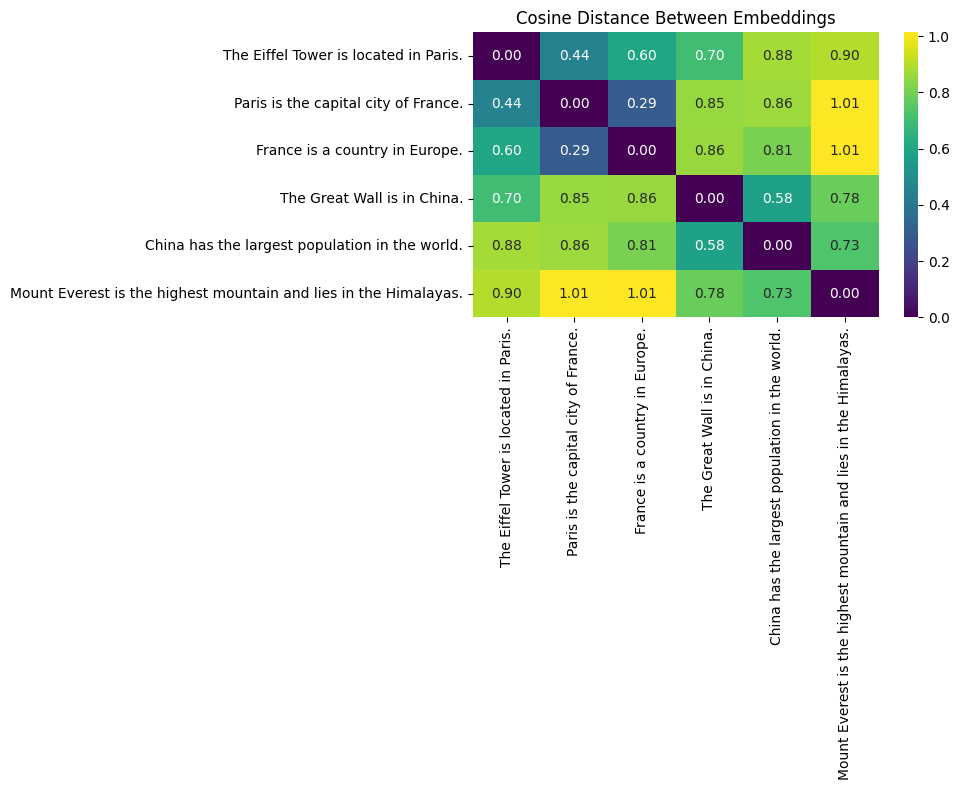

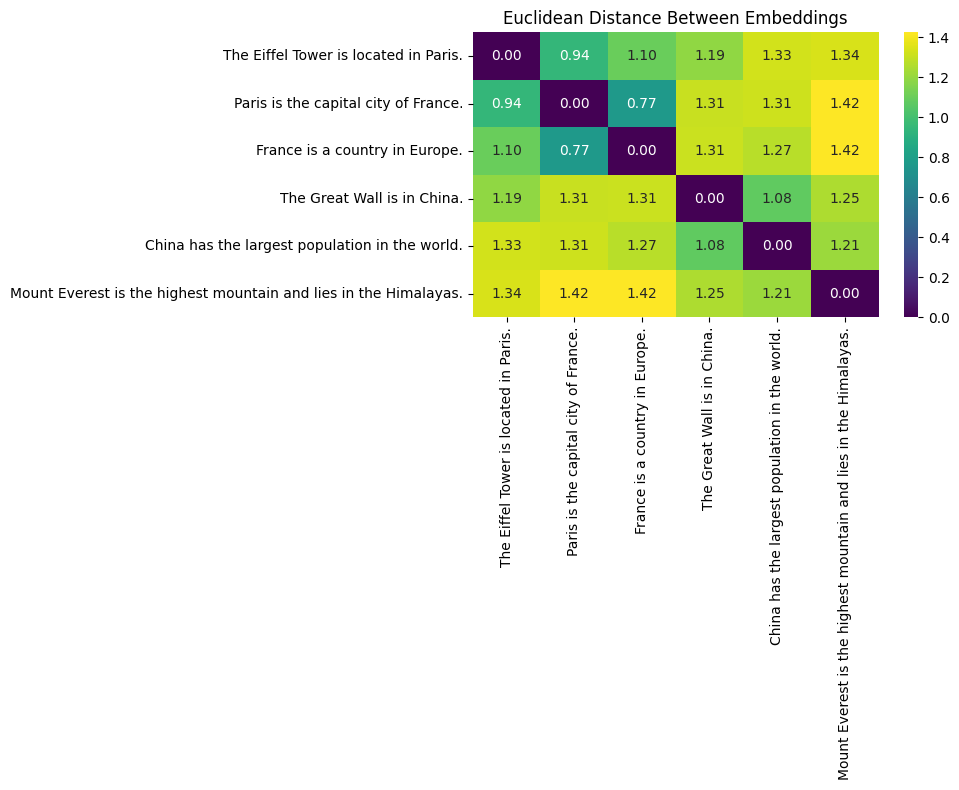

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

# --- Example data (replace with yours) ---
# embeddings = np.array([...]) # Remove this line
# texts = ["Paris is...", "Eiffel Tower is...", ...]

texts = [
    "The Eiffel Tower is located in Paris.",
    "Paris is the capital city of France.",
    "France is a country in Europe.",
    "The Great Wall is in China.",
    "China has the largest population in the world.",
    "Mount Everest is the highest mountain and lies in the Himalayas.",
]

# query = "Where is the Eiffel Tower?" # Remove this line

# Normalize embeddings (for cosine)
# Use doc_embeddings instead of the combined embeddings
normed_embeddings = doc_embeddings / np.linalg.norm(doc_embeddings, axis=1, keepdims=True)

# --- Calculate pairwise distances ---
cos_dist = cosine_distances(normed_embeddings)
euc_dist = euclidean_distances(doc_embeddings) # Use doc_embeddings here as well

# --- Create a heatmap ---
def plot_heatmap(dist_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_matrix, xticklabels=texts, yticklabels=texts, annot=True, fmt=".2f", cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- Visualize ---
plot_heatmap(cos_dist, "Cosine Distance Between Embeddings")
plot_heatmap(euc_dist, "Euclidean Distance Between Embeddings")

In [10]:
!pip install -q sentence-transformers


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

/tmp/ipython-input-4121305689.py:37: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



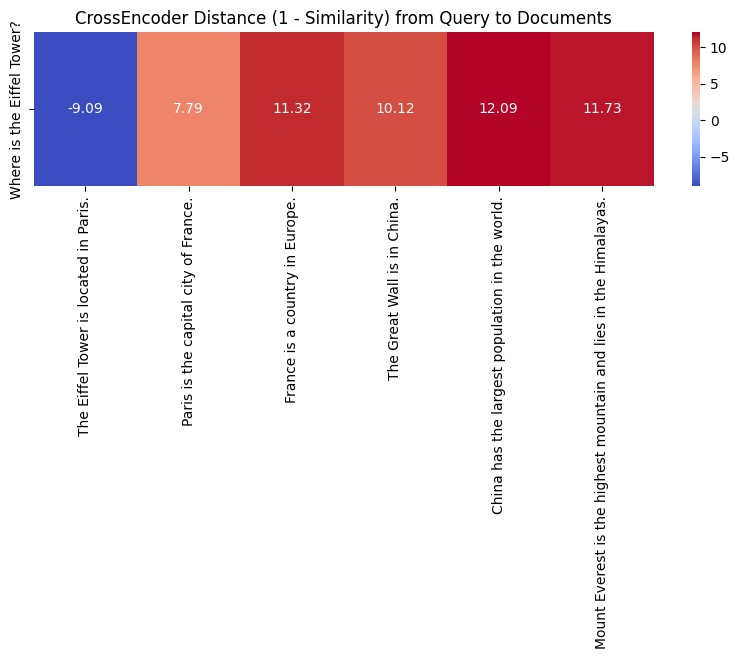

In [11]:
from sentence_transformers import CrossEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample documents
texts = [
    "The Eiffel Tower is located in Paris.",
    "Paris is the capital city of France.",
    "France is a country in Europe.",
    "The Great Wall is in China.",
    "China has the largest population in the world.",
    "Mount Everest is the highest mountain and lies in the Himalayas.",
]

# Query
query = "Where is the Eiffel Tower?"

# Load CrossEncoder model
cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Create query-document pairs
pairs = [[query, doc] for doc in texts]

# Predict similarity scores
scores = cross_model.predict(pairs)

# Convert similarity to pseudo-distance (1 - similarity)
cross_dist = 1 - np.array(scores).reshape(1, -1)

# Visualize using heatmap
def plot_query_heatmap(distances, texts, title):
    plt.figure(figsize=(10, 2))
    sns.heatmap(distances, xticklabels=texts, yticklabels=[query], annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_query_heatmap(cross_dist, texts, "CrossEncoder Distance (1 - Similarity) from Query to Documents")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

/tmp/ipython-input-2560261436.py:55: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



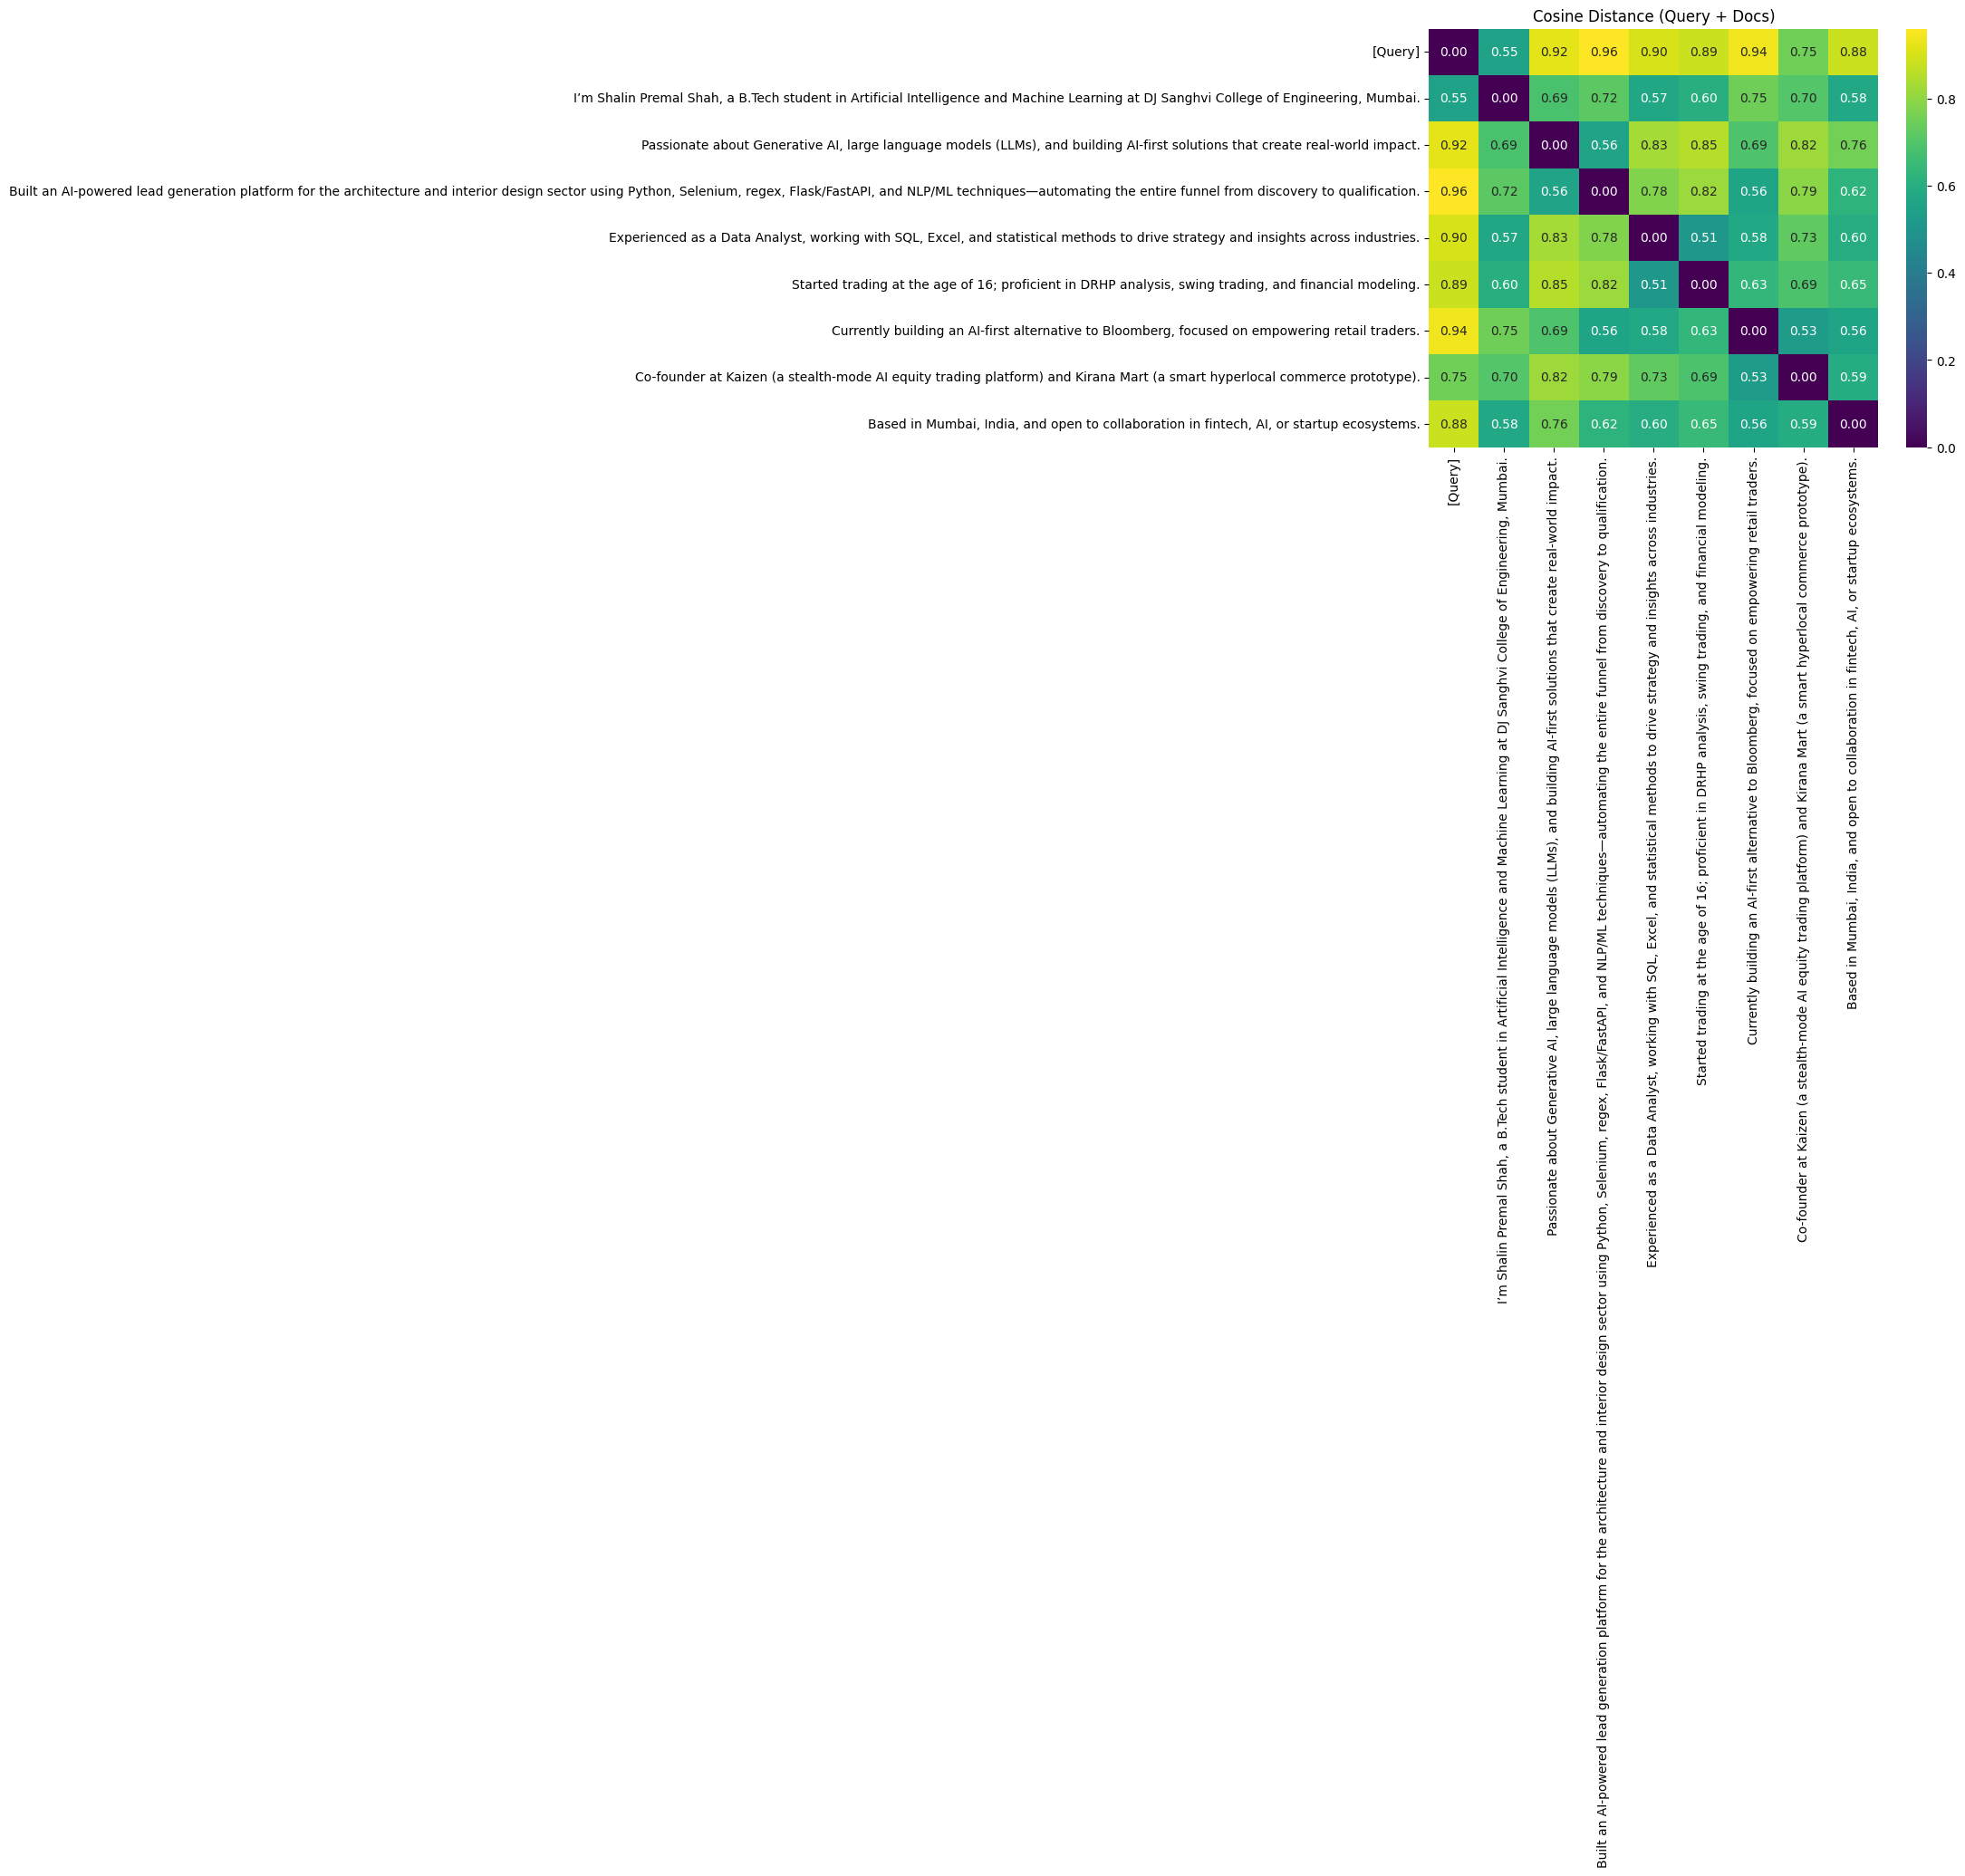

/tmp/ipython-input-2560261436.py:63: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



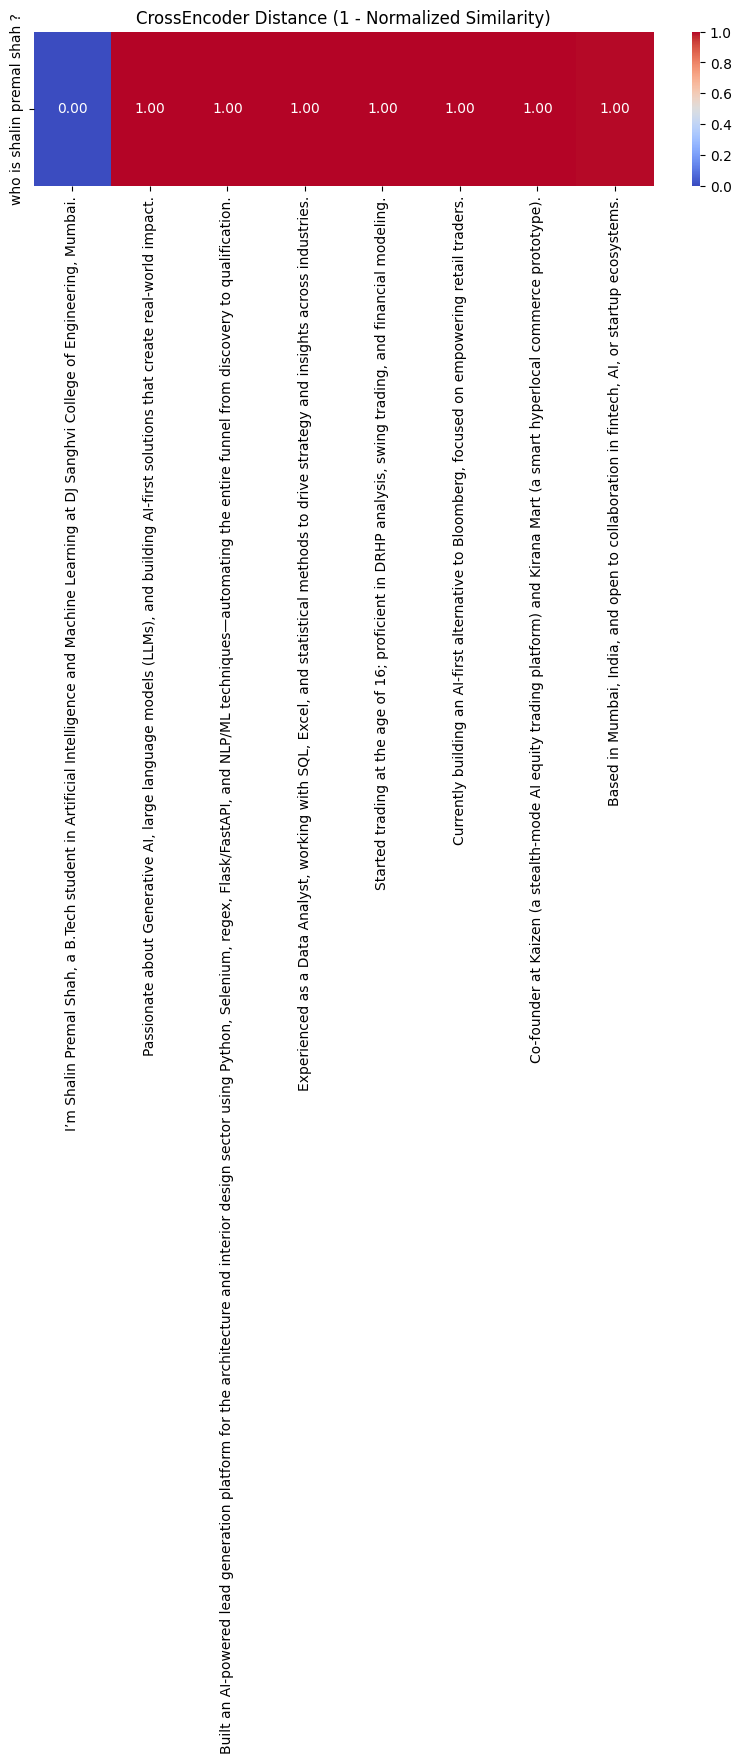

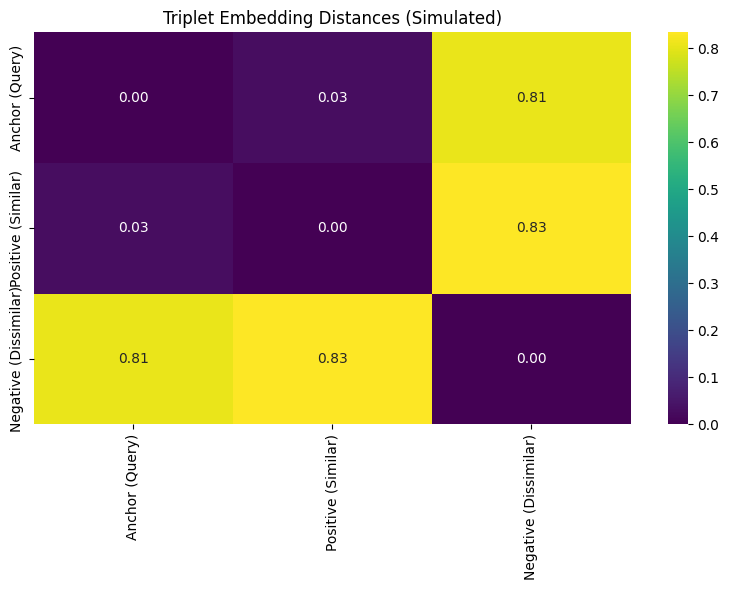

In [14]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define texts and query ---
texts = [
    "I’m Shalin Premal Shah, a B.Tech student in Artificial Intelligence and Machine Learning at DJ Sanghvi College of Engineering, Mumbai.",
    "Passionate about Generative AI, large language models (LLMs), and building AI-first solutions that create real-world impact.",
    "Built an AI-powered lead generation platform for the architecture and interior design sector using Python, Selenium, regex, Flask/FastAPI, and NLP/ML techniques—automating the entire funnel from discovery to qualification.",
    "Experienced as a Data Analyst, working with SQL, Excel, and statistical methods to drive strategy and insights across industries.",
    "Started trading at the age of 16; proficient in DRHP analysis, swing trading, and financial modeling.",
    "Currently building an AI-first alternative to Bloomberg, focused on empowering retail traders.",
    "Co-founder at Kaizen (a stealth-mode AI equity trading platform) and Kirana Mart (a smart hyperlocal commerce prototype).",
    "Based in Mumbai, India, and open to collaboration in fintech, AI, or startup ecosystems."
]
query = "who is shalin premal shah ?"

# --- Load models ---
bi_encoder = SentenceTransformer('all-MiniLM-L6-v2')  # For embeddings
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')  # For pairwise scoring

# --- Generate embeddings ---
doc_embeddings = bi_encoder.encode(texts, normalize_embeddings=True)
query_embedding = bi_encoder.encode([query], normalize_embeddings=True)

# --- Cosine Distance ---
all_embeddings = np.vstack([query_embedding, doc_embeddings])
cos_dist = cosine_distances(all_embeddings)

# --- CrossEncoder Similarity Scores ---
cross_pairs = [[query, doc] for doc in texts]
cross_scores = cross_encoder.predict(cross_pairs)

# --- Normalize CrossEncoder scores ---
cross_scores = np.array(cross_scores)
normalized_scores = (cross_scores - cross_scores.min()) / (cross_scores.max() - cross_scores.min())  # scale to [0, 1]
cross_dist = 1 - normalized_scores.reshape(1, -1)

# --- Simulated Triplet Embeddings ---
anchor = np.array([0.5, 0.2])
positive = np.array([0.52, 0.18])
negative = np.array([0.1, 0.9])
triplet_embeddings = np.array([anchor, positive, negative])
triplet_labels = ['Anchor (Query)', 'Positive (Similar)', 'Negative (Dissimilar)']
triplet_dist = euclidean_distances(triplet_embeddings)

# --- Plotting Functions ---
def plot_heatmap(matrix, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f", cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_query_heatmap(distances, labels, title):
    plt.figure(figsize=(10, 2))
    sns.heatmap(distances, xticklabels=labels, yticklabels=[query], annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# --- Plot Heatmaps ---
cos_labels = ["[Query]"] + texts
plot_heatmap(cos_dist, cos_labels, "Cosine Distance (Query + Docs)")

plot_query_heatmap(cross_dist, texts, "CrossEncoder Distance (1 - Normalized Similarity)")

plot_heatmap(triplet_dist, triplet_labels, "Triplet Embedding Distances (Simulated)")
